In [158]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras import layers
import random
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import itertools

In [30]:
rootDir = './animals-dataset'
trainingDir = rootDir + '/training'
testDir = rootDir + '/test'

In [31]:
seed = 512
validation_split = 0.2
interpolation = "bilinear"
batch_size = 32
img_height = 256
img_width = 256

In [18]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    trainingDir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    interpolation=interpolation
)

Found 5000 files belonging to 10 classes.
Using 4000 files for training.


In [19]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    trainingDir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    interpolation=interpolation
)

Found 5000 files belonging to 10 classes.
Using 1000 files for validation.


In [32]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    testDir,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    interpolation=interpolation
)

Found 1000 files belonging to 10 classes.


In [20]:
class_names = train_ds.class_names
print(class_names)

['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elefant', 'horse', 'sheep', 'spider', 'squirrel']


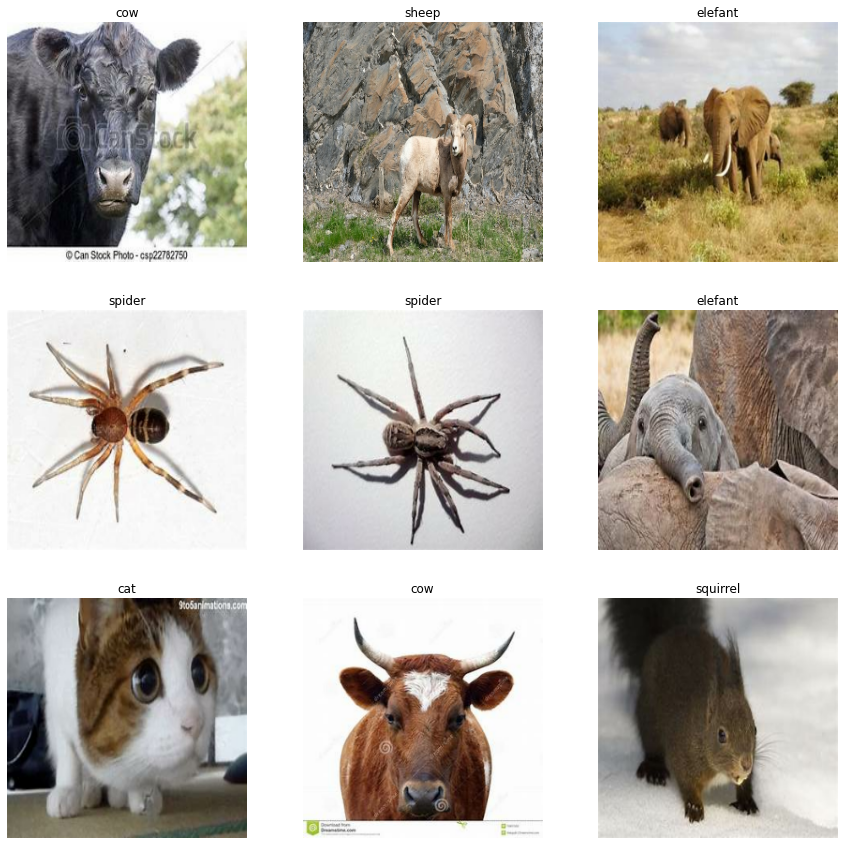

In [21]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [76]:
num_classes = 10

#    layers.UpSampling2D(),
#    layers.Conv2D(32, 2, activation='relu'),
#    layers.UpSampling2D(),
#    layers.Conv2D(64, 2, activation='relu'),
#    layers.UpSampling2D(),
#    layers.Conv2D(128, 2, activation='relu'),
    
model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(8, 2, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(4, 2, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(2, 2, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.UpSampling2D(),
    layers.Conv2D(2, 2, activation='relu'),
    layers.UpSampling2D(),
    layers.Conv2D(4, 2, activation='relu'),
    layers.UpSampling2D(),
    layers.Conv2D(8, 2, activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [77]:
model.compile(
  optimizer=tf.optimizers.Adam(learning_rate=0.001),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [78]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
125/125 [==============================] - 64s 512ms/step - loss: 2.2382 - accuracy: 0.1610 - val_loss: 2.2478 - val_accuracy: 0.1860
Epoch 2/10
125/125 [==============================] - 65s 519ms/step - loss: 1.9824 - accuracy: 0.2998 - val_loss: 2.1390 - val_accuracy: 0.2190
Epoch 3/10
125/125 [==============================] - 64s 516ms/step - loss: 1.7700 - accuracy: 0.3750 - val_loss: 2.1164 - val_accuracy: 0.2470
Epoch 4/10
125/125 [==============================] - 64s 516ms/step - loss: 1.5694 - accuracy: 0.4557 - val_loss: 2.1453 - val_accuracy: 0.2360
Epoch 5/10
125/125 [==============================] - 64s 514ms/step - loss: 1.3626 - accuracy: 0.5173 - val_loss: 2.2228 - val_accuracy: 0.2120
Epoch 6/10
125/125 [==============================] - 65s 519ms/step - loss: 1.2152 - accuracy: 0.5790 - val_loss: 2.2513 - val_accuracy: 0.2230
Epoch 7/10
125/125 [==============================] - 64s 511ms/step - loss: 1.0759 - accuracy: 0.6428 - val_loss: 2.3178 - val_ac

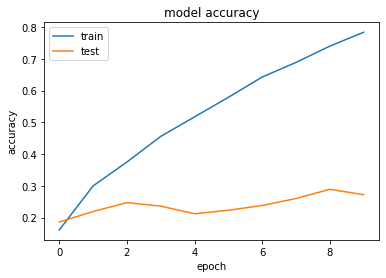

In [79]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

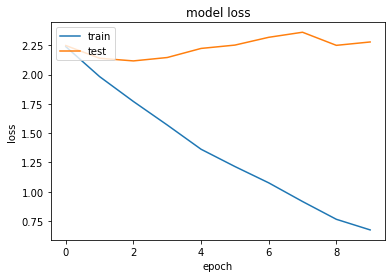

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [81]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)

32/32 [==============================] - 6s 186ms/step - loss: 2.1719 - accuracy: 0.2890


In [82]:
print('Test accuracy: ' +  str(test_acc) + " Loss: " + str(test_loss))

Test accuracy: 0.289000004529953 Loss: 2.1718571186065674


In [83]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_ds)

In [84]:
predictions[0]

array([0.00199977, 0.00810499, 0.23587877, 0.14216623, 0.0083089 ,
       0.10125383, 0.04384845, 0.4439542 , 0.00195798, 0.01252684],
      dtype=float32)

In [85]:
np.argmax(predictions[0])

7

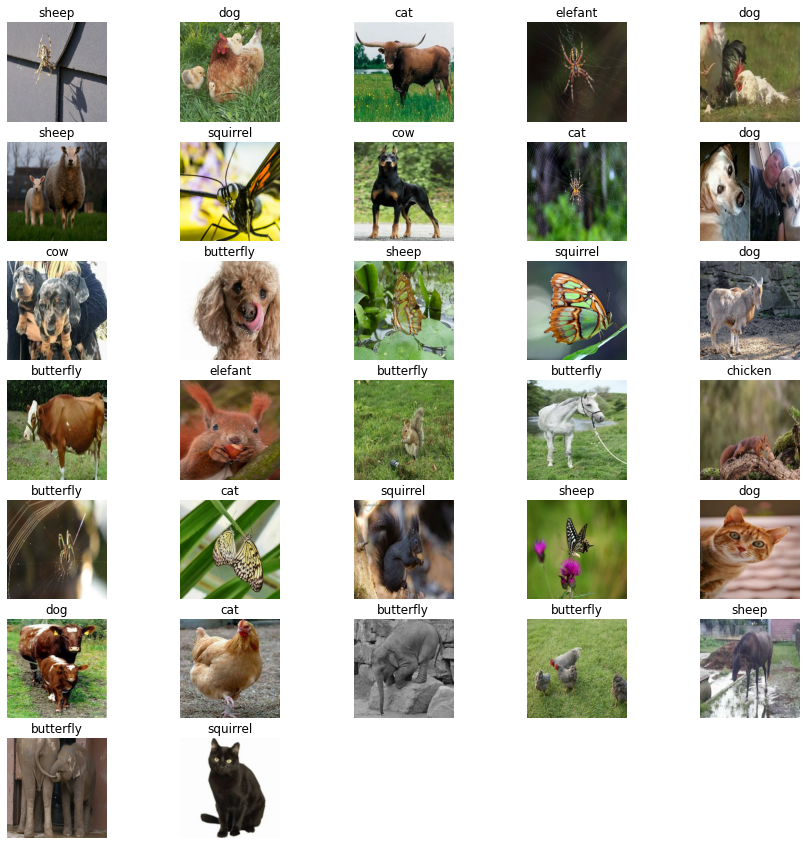

In [86]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(batch_size):
        ax = plt.subplot(7, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(predictions[i])])
        plt.axis("off")
#https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix

In [129]:
prediction_counter = 0
l = []
p = []
for images, labels in test_ds:
    for i in range(len(labels)):
        l.append(labels[i].numpy())
        p.append(np.argmax(predictions[prediction_counter]))
        prediction_counter += 1

[7,
 4,
 1,
 5,
 4,
 7,
 9,
 3,
 1,
 4,
 3,
 0,
 7,
 9,
 4,
 0,
 5,
 0,
 0,
 2,
 0,
 1,
 9,
 7,
 4,
 4,
 1,
 0,
 0,
 7,
 0,
 9,
 3,
 9,
 6,
 9,
 0,
 1,
 7,
 1,
 4,
 1,
 9,
 1,
 7,
 7,
 9,
 4,
 1,
 0,
 9,
 1,
 2,
 0,
 1,
 9,
 9,
 1,
 5,
 1,
 8,
 1,
 3,
 9,
 7,
 0,
 4,
 0,
 9,
 4,
 7,
 1,
 0,
 0,
 1,
 8,
 1,
 9,
 4,
 4,
 3,
 1,
 5,
 3,
 5,
 9,
 7,
 0,
 5,
 0,
 7,
 1,
 3,
 1,
 2,
 9,
 9,
 3,
 1,
 9,
 9,
 1,
 0,
 2,
 9,
 0,
 9,
 2,
 7,
 4,
 4,
 2,
 9,
 1,
 6,
 4,
 0,
 1,
 5,
 3,
 2,
 2,
 9,
 9,
 4,
 9,
 3,
 0,
 5,
 8,
 8,
 9,
 1,
 4,
 9,
 9,
 6,
 8,
 2,
 1,
 9,
 2,
 6,
 9,
 5,
 9,
 7,
 5,
 9,
 9,
 2,
 3,
 9,
 7,
 3,
 5,
 1,
 9,
 4,
 8,
 5,
 6,
 9,
 7,
 1,
 3,
 0,
 9,
 9,
 1,
 5,
 7,
 0,
 1,
 9,
 3,
 8,
 1,
 3,
 5,
 4,
 1,
 8,
 4,
 9,
 0,
 0,
 1,
 1,
 9,
 4,
 1,
 4,
 7,
 0,
 4,
 7,
 4,
 3,
 8,
 5,
 9,
 7,
 4,
 9,
 0,
 0,
 0,
 9,
 0,
 2,
 7,
 7,
 5,
 9,
 7,
 7,
 1,
 0,
 1,
 0,
 0,
 7,
 0,
 5,
 4,
 9,
 1,
 7,
 8,
 1,
 3,
 7,
 9,
 9,
 3,
 1,
 1,
 9,
 7,
 9,
 0,
 2,
 2,
 3,
 7,
 0,
 1,
 1,
 9,


In [162]:
cm = tf.math.confusion_matrix(l, p)
cm = cm / 1000

0.009

In [166]:
# https://docs.python.org/3/library/itertools.html#module-itertools
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Use white text if squares are dark; otherwise black.
    threshold = np.max(cm) / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j].numpy(), horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return figure

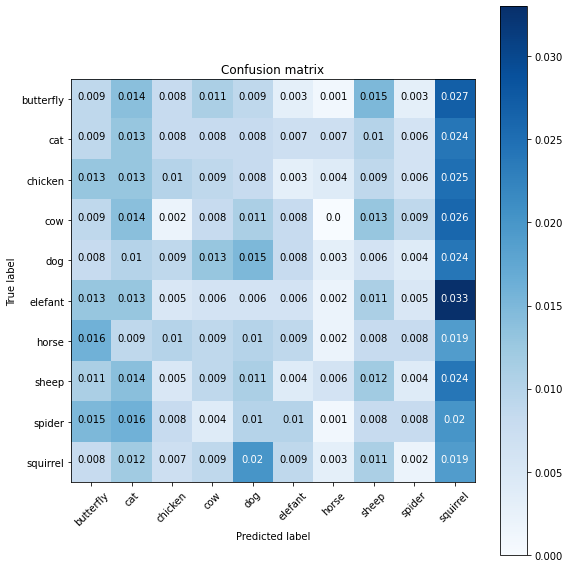

In [167]:
plot_confusion_matrix(cm, class_names)